In [6]:
!pip install d2l==0.15.1
!pip install -U mxnet-cu101==1.7.0


Requirement already up-to-date: mxnet-cu101==1.7.0 in /usr/local/lib/python3.6/dist-packages (1.7.0)


In [7]:
%matplotlib inline
from d2l import mxnet as d2l
from mxnet import autograd, gluon, image, init, np, npx
from mxnet.gluon import nn

npx.set_np()

def cls_predictor(num_anchors, num_classes):
    return nn.Conv2D(num_anchors * (num_classes + 1), kernel_size=3,
                     padding=1)
def bbox_predictor(num_anchors):
    return nn.Conv2D(num_anchors * 4, kernel_size=3, padding=1)
def forward(x, block):
    block.initialize()
    return block(x)

Y1 = forward(np.zeros((2, 8, 20, 20)), cls_predictor(5, 10))
Y2 = forward(np.zeros((2, 16, 10, 10)), cls_predictor(3, 10))

def flatten_pred(pred):
    return npx.batch_flatten(pred.transpose(0, 2, 3, 1))

def concat_preds(preds):
    return np.concatenate([flatten_pred(p) for p in preds], axis=1)
def down_sample_blk(num_channels):
    blk = nn.Sequential()
    for _ in range(2):
        blk.add(nn.Conv2D(num_channels, kernel_size=3, padding=1),
                nn.BatchNorm(in_channels=num_channels),
                nn.Activation('relu'))
    blk.add(nn.MaxPool2D(2))
    return blk

forward(np.zeros((2, 3, 20, 20)), down_sample_blk(10)).shape

(2, 10, 10, 10)

In [ ]:
#AlexNet Variant

def base_net():
    blk = nn.Sequential()
    
    for num_filters in [16, 32, 64]:
        blk.add(down_sample_blk(num_filters))
    
    return blk
    blk.add(nn.Conv2D(96, kernel_size=11, strides=4, activation='relu'),
      nn.MaxPool2D(pool_size=3, strides=2),
      
      nn.Conv2D(256, kernel_size=5, padding=2, activation='relu'),
      nn.MaxPool2D(pool_size=3, strides=2), 
      nn.Conv2D(384, kernel_size=3, padding=1, activation='relu'),
      nn.Conv2D(384, kernel_size=3, padding=1, activation='relu'),
      nn.Conv2D(256, kernel_size=3, padding=1, activation='relu'),
      nn.MaxPool2D(pool_size=3, strides=2), 
      nn.Dense(4096, activation='relu'), nn.Dropout(0.5),
      nn.Dense(4096, activation='relu'), nn.Dropout(0.5),
      nn.Dense(10))

forward(np.zeros((2, 3, 256, 256)), base_net()).shape

(2, 64, 32, 32)

In [ ]:
#VGG-11
def base_net():
    blk = nn.Sequential()
    for num_filters in [16, 32, 64]:
        blk.add(down_sample_blk(num_filters))
    return blk
    blk.add(nn.Conv2D(64, kernel_size=11, strides=4, activation='relu'),
      nn.MaxPool2D(pool_size=3, strides=2),
      
      nn.Conv2D(128, kernel_size=5, padding=2, activation='relu'),
      nn.MaxPool2D(pool_size=3, strides=2), 
      nn.Conv2D(256, kernel_size=3, padding=1, activation='relu'),
      nn.Conv2D(256, kernel_size=3, padding=1, activation='relu'),
      nn.MaxPool2D(pool_size=3, strides=2), 
      nn.Conv2D(512, kernel_size=3, padding=1, activation='relu'),
      nn.Conv2D(512, kernel_size=3, padding=1, activation='relu'),
      nn.MaxPool2D(pool_size=3, strides=2), 
      nn.Conv2D(512, kernel_size=3, padding=1, activation='relu'),
      nn.Conv2D(512, kernel_size=3, padding=1, activation='relu'),
      nn.MaxPool2D(pool_size=3, strides=2), 
      nn.MaxPool2D(pool_size=3, strides=2), 
      nn.Dense(4096, activation='relu'), nn.Dropout(0.5),
      nn.Dense(4096, activation='relu'), nn.Dropout(0.5),
      nn.Dense(10))

forward(np.zeros((2, 3, 256, 256)), base_net()).shape

(2, 64, 32, 32)

In [ ]:
#NIN
def nin_block(num_channels, kernel_size, strides, padding):
    net = nn.Sequential()
    net.add(nn.Conv2D(num_channels, kernel_size, strides, padding,
                      activation='relu'),
            nn.Conv2D(num_channels, kernel_size=1, activation='relu'),
            nn.Conv2D(num_channels, kernel_size=1, activation='relu'))
    return net
def base_net():
    blk = nn.Sequential()
    for num_filters in [16, 32, 64]:
        blk.add(down_sample_blk(num_filters))
    return blk
blk = nn.Sequential()
blk.add(nin_block(96, kernel_size=11, strides=4, padding=0),
        nn.MaxPool2D(pool_size=3, strides=2),
        nin_block(256, kernel_size=5, strides=1, padding=2),
        nn.MaxPool2D(pool_size=3, strides=2),
        nin_block(384, kernel_size=3, strides=1, padding=1),
        nn.MaxPool2D(pool_size=3, strides=2),
        nn.Dropout(0.5),
        nin_block(10, kernel_size=3, strides=1, padding=1),
        nn.GlobalAvgPool2D(),
        nn.Flatten())
forward(np.zeros((2, 3, 256, 256)), base_net()).shape

(2, 64, 32, 32)

In [ ]:
#GoogleNet
class Inception(nn.Block):
    def __init__(self, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        self.p1_1 = nn.Conv2D(c1, kernel_size=1, activation='relu')
        self.p2_1 = nn.Conv2D(c2[0], kernel_size=1, activation='relu')
        self.p2_2 = nn.Conv2D(c2[1], kernel_size=3, padding=1,
                              activation='relu')
        self.p3_1 = nn.Conv2D(c3[0], kernel_size=1, activation='relu')
        self.p3_2 = nn.Conv2D(c3[1], kernel_size=5, padding=2,
                              activation='relu')
        self.p4_1 = nn.MaxPool2D(pool_size=3, strides=1, padding=1)
        self.p4_2 = nn.Conv2D(c4, kernel_size=1, activation='relu')

    def forward(self, x):
        p1 = self.p1_1(x)
        p2 = self.p2_2(self.p2_1(x))
        p3 = self.p3_2(self.p3_1(x))
        p4 = self.p4_2(self.p4_1(x))
        return np.concatenate((p1, p2, p3, p4), axis=1)

def base_net():
  blk = nn.Sequential()
  for num_filters in [16, 32, 64]:
      blk.add(down_sample_blk(num_filters))
  return blk
  b1 = nn.Sequential()
  b1.add(nn.Conv2D(64, kernel_size=7, strides=2, padding=3, activation='relu'),
       nn.MaxPool2D(pool_size=3, strides=2, padding=1))
  
  b2 = nn.Sequential()
  b2.add(nn.Conv2D(64, kernel_size=1, activation='relu'),
       nn.Conv2D(192, kernel_size=3, padding=1, activation='relu'),
       nn.MaxPool2D(pool_size=3, strides=2, padding=1))
  
  b3 = nn.Sequential()
  b3.add(Inception(64, (96, 128), (16, 32), 32),
       Inception(128, (128, 192), (32, 96), 64),
       nn.MaxPool2D(pool_size=3, strides=2, padding=1))
  
  b4 = nn.Sequential()
  b4.add(Inception(192, (96, 208), (16, 48), 64),
       Inception(160, (112, 224), (24, 64), 64),
       Inception(128, (128, 256), (24, 64), 64),
       Inception(112, (144, 288), (32, 64), 64),
       Inception(256, (160, 320), (32, 128), 128),
       nn.MaxPool2D(pool_size=3, strides=2, padding=1))
  
  b5 = nn.Sequential()
  b5.add(Inception(256, (160, 320), (32, 128), 128),
       Inception(384, (192, 384), (48, 128), 128),
       nn.GlobalAvgPool2D())

  blk = nn.Sequential()
  blk.add(b1, b2, b3, b4, b5, nn.Dense(10))

  return blk

forward(np.zeros((2, 3, 256, 256)), base_net()).shape

(2, 64, 32, 32)

In [14]:
#ResNet
class Residual(nn.Block):  
    def __init__(self, num_channels, use_1x1conv=False, strides=1, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = nn.Conv2D(num_channels, kernel_size=3, padding=1,
                               strides=strides)
        self.conv2 = nn.Conv2D(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2D(num_channels, kernel_size=1,
                                   strides=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm()
        self.bn2 = nn.BatchNorm()

    def forward(self, X):
        Y = npx.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        return npx.relu(Y + X)

def base_net():
  blk = nn.Sequential()
  for num_filters in [16, 32, 64]:
      blk.add(down_sample_blk(num_filters))
  return blk
blk = Residual(3)
forward(np.zeros((2, 3, 256, 256)), base_net()).shape

(2, 64, 32, 32)

In [20]:
#DenseNet
def conv_block(num_channels):
    blk = nn.Sequential()
    blk.add(nn.BatchNorm(),
            nn.Activation('relu'),
            nn.Conv2D(num_channels, kernel_size=3, padding=1))
    return blk

class DenseBlock(nn.Block):
    def __init__(self, num_convs, num_channels, **kwargs):
        super().__init__(**kwargs)
        self.net = nn.Sequential()
        for _ in range(num_convs):
            self.net.add(conv_block(num_channels))

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            X = np.concatenate((X, Y), axis=1)
        return X
def base_net():
  blk = nn.Sequential()
  for num_filters in [16, 32, 64]:
      blk.add(down_sample_blk(num_filters))
  return blk
blk = DenseBlock(2, 10)
forward(np.zeros((2, 3, 256, 256)), base_net()).shape

(2, 64, 32, 32)

In [21]:
def get_blk(i):
    if i == 0:
        blk = base_net()
    elif i == 4:
        blk = nn.GlobalMaxPool2D()
    else:
        blk = down_sample_blk(128)
    return blk

def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    Y = blk(X)
    anchors = npx.multibox_prior(Y, sizes=size, ratios=ratio)
    cls_preds = cls_predictor(Y)
    bbox_preds = bbox_predictor(Y)
    return (Y, anchors, cls_preds, bbox_preds)

sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],
         [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1

class TinySSD(nn.Block):
    def __init__(self, num_classes, **kwargs):
        super(TinySSD, self).__init__(**kwargs)
        self.num_classes = num_classes
        for i in range(5):
            setattr(self, f'blk_{i}', get_blk(i))
            setattr(self, f'cls_{i}', cls_predictor(num_anchors, num_classes))
            setattr(self, f'bbox_{i}', bbox_predictor(num_anchors))

    def forward(self, X):
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        for i in range(5):
            X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(
                X, getattr(self, f'blk_{i}'), sizes[i], ratios[i],
                getattr(self, f'cls_{i}'), getattr(self, f'bbox_{i}'))
        anchors = np.concatenate(anchors, axis=1)
        cls_preds = concat_preds(cls_preds)
        cls_preds = cls_preds.reshape(
            cls_preds.shape[0], -1, self.num_classes + 1)
        bbox_preds = concat_preds(bbox_preds)
        return anchors, cls_preds, bbox_preds

net = TinySSD(num_classes=1)
net.initialize()
X = np.zeros((32, 3, 256, 256))
anchors, cls_preds, bbox_preds = net(X)

batch_size = 32
train_iter, _ = d2l.load_data_bananas(batch_size)

device, net = d2l.try_gpu(), TinySSD(num_classes=1)
net.initialize(init=init.Xavier(), ctx=device)
trainer = gluon.Trainer(net.collect_params(), 'adam',
                        {'learning_rate': 0.2, 'wd': 5e-4})

cls_loss = gluon.loss.SoftmaxCrossEntropyLoss()
bbox_loss = gluon.loss.L1Loss()

def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    cls = cls_loss(cls_preds, cls_labels)
    bbox = bbox_loss(bbox_preds * bbox_masks, bbox_labels * bbox_masks)
    return cls + bbox

def cls_eval(cls_preds, cls_labels):
    return float((cls_preds.argmax(axis=-1).astype(
        cls_labels.dtype) == cls_labels).sum())

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return float((np.abs((bbox_labels - bbox_preds) * bbox_masks)).sum())



class err 6.48e-03, bbox mae 6.88e-03
5547.7 examples/sec on gpu(0)


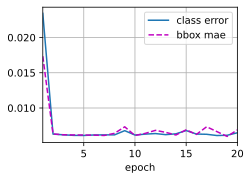

In [23]:
num_epochs, timer = 20, d2l.Timer()
animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                        legend=['class error', 'bbox mae'])
for epoch in range(num_epochs):
    metric = d2l.Accumulator(4)
    train_iter.reset()  
    for batch in train_iter:
        timer.start()
        X = batch.data[0].as_in_ctx(device)
        Y = batch.label[0].as_in_ctx(device)
        with autograd.record():
            anchors, cls_preds, bbox_preds = net(X)
            bbox_labels, bbox_masks, cls_labels = npx.multibox_target(
                anchors, Y, cls_preds.transpose(0, 2, 1))
            l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels,
                          bbox_masks)
        l.backward()
        trainer.step(batch_size)
        metric.add(cls_eval(cls_preds, cls_labels), cls_labels.size,
                   bbox_eval(bbox_preds, bbox_labels, bbox_masks),
                   bbox_labels.size)
    cls_err, bbox_mae = 1-metric[0]/metric[1], metric[2]/metric[3]
    animator.add(epoch+1, (cls_err, bbox_mae))
print(f'class err {cls_err:.2e}, bbox mae {bbox_mae:.2e}')
print(f'{train_iter.num_image/timer.stop():.1f} examples/sec on '
      f'{str(device)}')